# Predicting Tsunamis (Binary Classification )

---
<a id='introduction'></a>
## 🎯 Introduction & Problem Overview

Tsunamis represent one of the most destructive geophysical hazards, with the ability to devastate coastal regions in an extremely short time frame. Historical events such as the **2004 Indian Ocean** and **2011 Tōhoku** tsunamis highlight the critical importance of building **reliable and timely early warning systems**.

### Problem Definition
Is it possible to infer tsunami likelihood using **seismic information alone**?  
This notebook explores a set of **machine learning–based classification models** designed to determine whether an earthquake is capable of generating a tsunami, using a curated dataset of **782 significant global seismic events** recorded between **2001 and 2022**.

### Practical Significance
- **Rapid Warning**: Early alerts are crucial for reducing casualties
- **Spatial Risk Awareness**: Supports identification of tsunami-prone regions
- **Feature Interpretability**: Reveals seismic patterns associated with tsunami generation
- **Scalable Automation**: Lays the groundwork for real-time monitoring systems

### Dataset Overview
- **782 earthquake records** collected over 22 years (2001–2022)
- **Class distribution**: 304 tsunami events (38.9%) and 478 non-tsunami events (61.1%)
- **Worldwide scope**: Latitude range −61.85° to 71.63°, Longitude −179.97° to 179.66°
- **13 seismic attributes**, including magnitude, depth, intensity, and geolocation
- **No missing values**, ensuring clean and reliable model training

Let’s move forward to uncover the seismic signals that differentiate tsunami-generating earthquakes 🌍🌊


In [1]:
# 🛠️ SYSTEM INITIALIZATION
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import warnings
import plotly.express as px
import lightgbm as lgb 

# Sklearn Core & Pipelines
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV, train_test_split,ParameterGrid, cross_validate
from sklearn.metrics import fbeta_score, make_scorer, classification_report, confusion_matrix, precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score
from sklearn.impute import SimpleImputer

# The Gladiators (Models)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.validation import check_is_fitted
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
SEED = 2

# Statistical Analysis
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr

print("✅ System Initialized. Libraries Loaded.")

✅ System Initialized. Libraries Loaded.


In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/global-earthquake-tsunami-risk-assessment-dataset/earthquake_data_tsunami.csv')

# Display basic information
print("🌍 GLOBAL EARTHQUAKE-TSUNAMI DATASET")
print(f"\n📊 Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\n" + "="*70)

# First look at the data
df.head(10)

🌍 GLOBAL EARTHQUAKE-TSUNAMI DATASET

📊 Dataset Shape: 782 rows × 13 columns



,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.5960,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.7380,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.3460,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.1290,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.2780,2022,11,1
5,7.0,4,3,755,142,4.578,26.0,660.000,-26.0442,178.3810,2022,11,1
6,6.8,1,3,711,136,4.678,22.0,630.379,-25.9678,178.3630,2022,11,1
7,6.7,7,6,797,145,1.151,37.0,20.000,7.6712,-82.3396,2022,10,1
8,6.8,8,7,1179,175,2.137,92.0,20.000,18.3300,-102.9130,2022,9,1
9,7.6,9,8,1799,271,1.153,69.0,26.943,18.3667,-103.2520,2022,9,1




<a id='dataset'></a>
## 📊 Dataset Overview & Quality Assessment

Understanding our data is the foundation of any successful ML project. Let's examine the structure, quality, and composition of our seismic dataset.

In [3]:
# Comprehensive data quality report
print("🔍 DATA QUALITY ASSESSMENT")

# Basic info
print("\n1️⃣ DATASET STRUCTURE")
print(f"   • Total Records: {df.shape[0]:,}")
print(f"   • Total Features: {df.shape[1]}")
print(f"   • Memory Usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")

# Missing values
print("\n2️⃣ MISSING VALUES")
missing_count = df.isnull().sum().sum()
if missing_count == 0:
    print(f"   ✅ PERFECT! Zero missing values across all features")
else:
    print(f"   ⚠️ Missing values detected: {missing_count}")

# Data types
print("\n3️⃣ DATA TYPES")
print(df.dtypes.value_counts())

# Duplicates
duplicates = df.duplicated().sum()
print(f"\n4️⃣ DUPLICATE ROWS")
if duplicates == 0:
    print(f"   ✅ No duplicate records found")
else:
    print(f"   ⚠️ {duplicates} duplicate rows detected")

🔍 DATA QUALITY ASSESSMENT

1️⃣ DATASET STRUCTURE
   • Total Records: 782
   • Total Features: 13
   • Memory Usage: 79.55 KB

2️⃣ MISSING VALUES
   ✅ PERFECT! Zero missing values across all features

3️⃣ DATA TYPES
int64      7
float64    6
Name: count, dtype: int64

4️⃣ DUPLICATE ROWS
   ✅ No duplicate records found




<a id='Preparation'></a>
## 🐍 Preparation

Before diving into data exploration and machine learning model development, we divided the dataset into an 85/15 split (train/test). On the training dataset, cross-validation is used throughout the development process. Our splitting method maintains the ratio of tsunami feature occurrences compared to the entire dataset to ensure accurate evaluation.

In [4]:
X = df.drop(columns=['tsunami']) 
y = df['tsunami']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,       
    random_state=3,     
    stratify=y           
)

print(f"\n✅ Train set: {X_train.shape[0]} samples")
print(f"✅ Test set:  {X_test.shape[0]} samples")

df = pd.concat([X_train, y_train], axis=1) # 85% dataframe is going to be used in EDA


✅ Train set: 664 samples
✅ Test set:  118 samples


## 🔬 Exploratory Data Analysis

In this section, we conduct a systematic exploration of the seismic dataset to reveal meaningful structures and trends. The analysis focuses on:

- **Statistical overview** of key seismic attributes  
- **Temporal behavior** of earthquake and tsunami events over time  
- **Spatial patterns** and identification of high-risk regions  
- **Magnitude–depth interactions** and their influence on tsunami generation  
- **Correlation analysis** between features and tsunami occurrence  
- **Evaluation of intensity-related metrics** and their predictive relevance  


In [5]:
print("\n📈 STATISTICAL SUMMARY\n")
display(df.describe().T.style.background_gradient(cmap='YlOrRd'))


📈 STATISTICAL SUMMARY



,count,mean,std,min,25%,50%,75%,max
magnitude,664.000000,6.942711,0.450551,6.500000,6.600000,6.800000,7.100000,9.100000
cdi,664.000000,4.293675,3.139716,0.000000,0.000000,5.000000,7.000000,9.000000
mmi,664.000000,5.944277,1.464995,1.000000,5.000000,6.000000,7.000000,9.000000
sig,664.000000,865.641566,322.247599,650.000000,691.000000,754.000000,902.250000,2910.000000
nst,664.000000,227.503012,250.101807,0.000000,0.000000,131.000000,443.250000,934.000000
dmin,664.000000,1.360294,2.197666,0.000000,0.000000,0.000000,1.987750,15.394000
gap,664.000000,24.396973,23.593996,0.000000,14.175000,20.000000,28.850000,239.000000
depth,664.000000,77.661038,137.954724,2.700000,14.957500,27.000000,55.000000,670.810000
latitude,664.000000,3.365298,27.238866,-61.848400,-14.867625,-3.167000,24.571500,71.631200
longitude,664.000000,55.151968,117.417329,-179.511000,-71.368550,120.102000,149.773750,179.662000


### 📊 Statistical Summary – Key Observations

- **Magnitude** values are tightly distributed (mean ≈ 6.94, std ≈ 0.45), indicating that the dataset focuses on **strong earthquakes**, which are more relevant for tsunami generation.
- **Intensity-related features** (`cdi`, `mmi`) show moderate variability, reflecting differences in felt shaking and potential surface impact across events.
- **Significance score (`sig`)** has a high mean (≈ 870) with large dispersion, confirming its role as a **composite indicator** of earthquake importance and its strong linkage to magnitude.
- **Network and distance metrics** (`nst`, `dmin`) exhibit high variance and many zero values, suggesting **uneven station coverage** and varying epicenter proximity, which may still carry predictive value.
- **Depth** spans a very wide range (≈ 3 km to > 670 km), but the median remains relatively shallow, aligning with the higher tsunami risk of shallow-focus earthquakes.
- **Geographic coordinates** (latitude, longitude) cover almost the entire globe, confirming the **global scope** of the dataset while hinting at regional clustering effects.
- **Temporal features** show concentration in recent years (median year ≈ 2013), consistent with improved seismic monitoring and reporting.
- The **tsunami label** indicates class imbalance (≈ 38.9% positive cases), reinforcing the need for **recall-focused metrics** (e.g., F2-score) and threshold optimization.



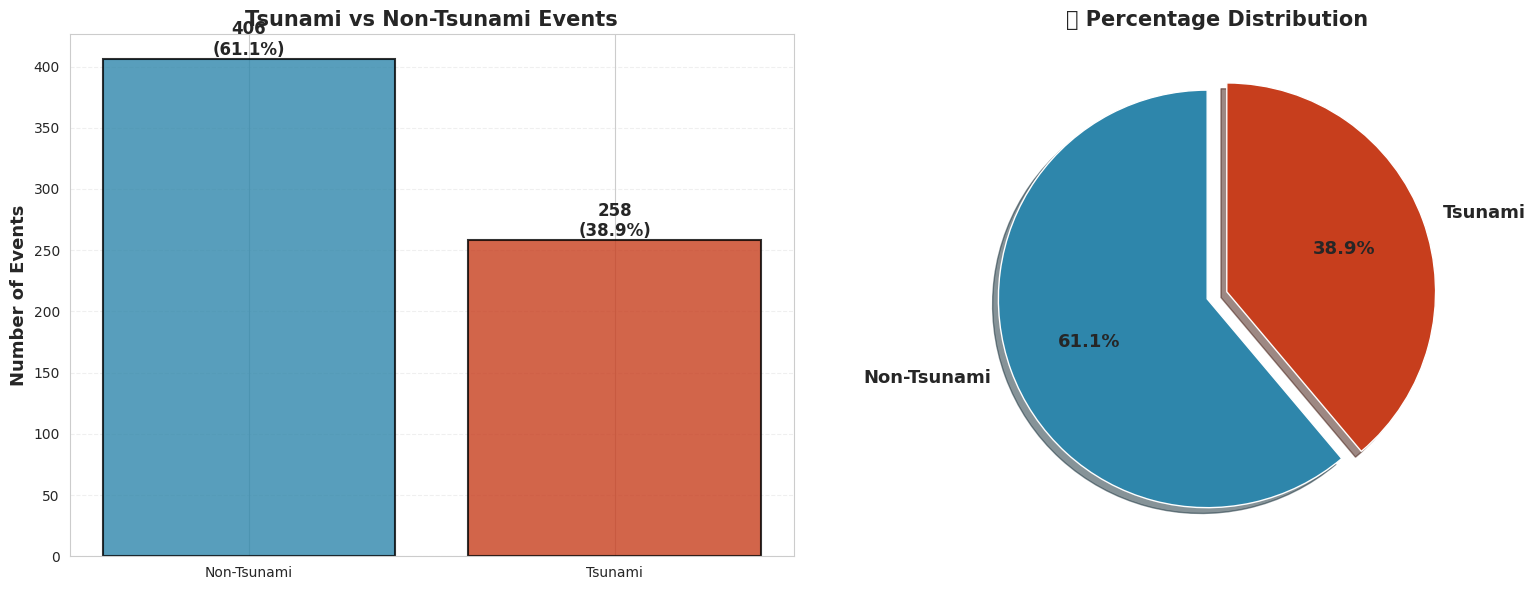

💡 KEY INSIGHTS: Target Distribution
✓ Dataset is moderately imbalanced (38.9% positive class)
✓ Non-Tsunami Events: 406 (61.1%)
✓ Tsunami Events: 258 (38.9%)


In [6]:
# EDA #1: Target Variable Distribution - The Foundation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
tsunami_counts = df['tsunami'].value_counts().sort_index()
tsunami_pct = df['tsunami'].value_counts(normalize=True) * 100

colors = ['#2E86AB', '#C73E1D']
bars = axes[0].bar(['Non-Tsunami', 'Tsunami'], tsunami_counts.values, color=colors, 
                   edgecolor='black', linewidth=1.5, alpha=0.8)
axes[0].set_ylabel('Number of Events', fontsize=13, fontweight='bold')
axes[0].set_title('Tsunami vs Non-Tsunami Events', fontsize=15, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({height/tsunami_counts.sum()*100:.1f}%)',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Pie chart
axes[1].pie(tsunami_counts.values, labels=['Non-Tsunami', 'Tsunami'], autopct='%1.1f%%',
           colors=colors, startangle=90, explode=(0.05, 0.05), shadow=True,
           textprops={'fontsize': 13, 'fontweight': 'bold'})
axes[1].set_title('📊 Percentage Distribution', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

# Key insights
print("="*70)
print("💡 KEY INSIGHTS: Target Distribution")
print("="*70)
print(f"✓ Dataset is moderately imbalanced ({tsunami_pct.iloc[1]:.1f}% positive class)")
print(f"✓ Non-Tsunami Events: {tsunami_counts.iloc[0]} ({tsunami_pct.iloc[0]:.1f}%)")
print(f"✓ Tsunami Events: {tsunami_counts.iloc[1]} ({tsunami_pct.iloc[1]:.1f}%)")

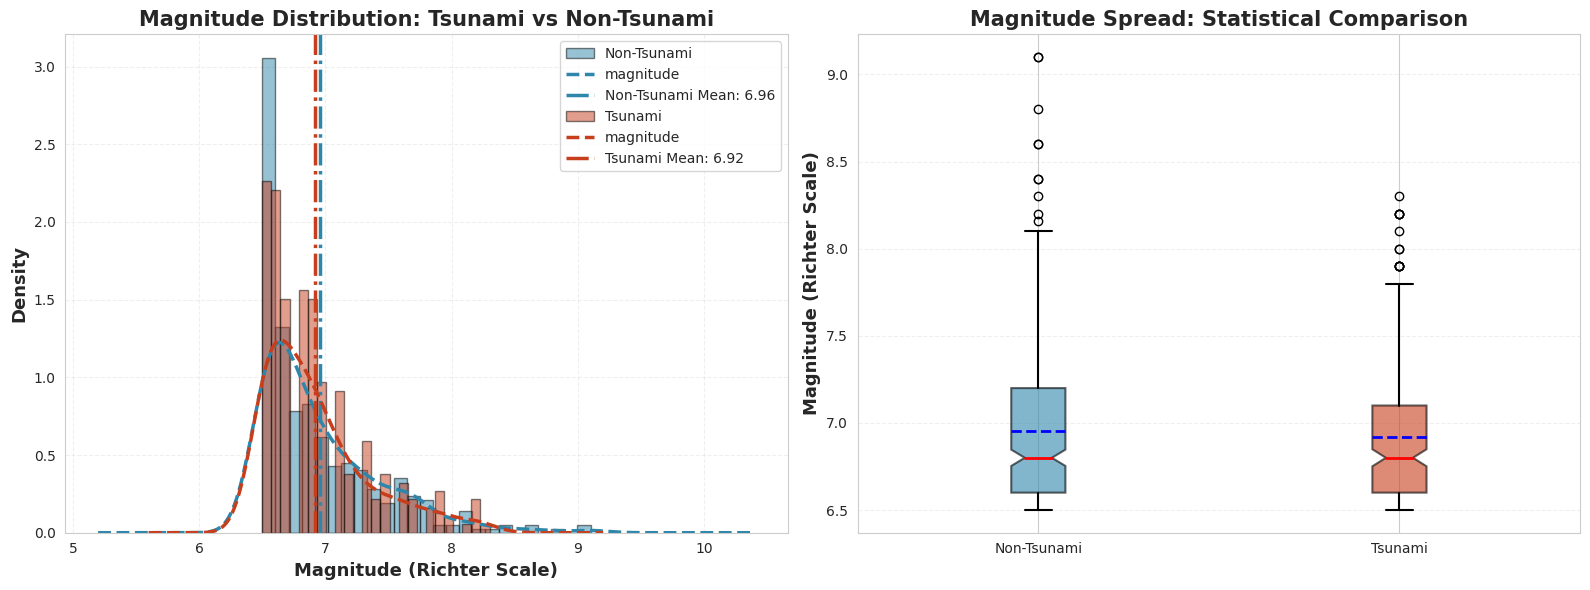

💡 KEY INSIGHTS: Magnitude Analysis
✓ Non-Tsunami Mean Magnitude: 6.957 ± 0.472
✓ Tsunami Mean Magnitude: 6.921 ± 0.414
✓ Magnitude Difference: 0.036 Richter units
✓ T-statistic: 0.9930 | P-value: 3.2107e-01
✓ No significant difference detected


In [7]:
# EDA #2: Magnitude Distribution by Tsunami Status
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Distribution comparison with KDE
for tsunami_val, label, color in [(0, 'Non-Tsunami', '#2E86AB'), (1, 'Tsunami', '#C73E1D')]:
    data = df[df['tsunami'] == tsunami_val]['magnitude']
    axes[0].hist(data, bins=25, alpha=0.5, label=label, color=color, edgecolor='black', density=True)
    data.plot(kind='kde', ax=axes[0], color=color, linewidth=2.5, linestyle='--')
    axes[0].axvline(data.mean(), color=color, linestyle='-.', linewidth=2.5, 
                    label=f'{label} Mean: {data.mean():.2f}')

axes[0].set_xlabel('Magnitude (Richter Scale)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Density', fontsize=13, fontweight='bold')
axes[0].set_title('Magnitude Distribution: Tsunami vs Non-Tsunami', fontsize=15, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(alpha=0.3, linestyle='--')

# Right: Box plot comparison
tsunami_data = [df[df['tsunami'] == 0]['magnitude'], df[df['tsunami'] == 1]['magnitude']]
bp = axes[1].boxplot(tsunami_data, labels=['Non-Tsunami', 'Tsunami'], patch_artist=True,
                     notch=True, showmeans=True, meanline=True,
                     boxprops=dict(linewidth=1.5),
                     whiskerprops=dict(linewidth=1.5),
                     capprops=dict(linewidth=1.5),
                     medianprops=dict(color='red', linewidth=2),
                     meanprops=dict(color='blue', linewidth=2))

for patch, color in zip(bp['boxes'], ['#2E86AB', '#C73E1D']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[1].set_ylabel('Magnitude (Richter Scale)', fontsize=13, fontweight='bold')
axes[1].set_title('Magnitude Spread: Statistical Comparison', fontsize=15, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.show()

# Statistical testing
non_tsunami_mag = df[df['tsunami'] == 0]['magnitude']
tsunami_mag = df[df['tsunami'] == 1]['magnitude']
t_stat, p_value = stats.ttest_ind(non_tsunami_mag, tsunami_mag)

print("="*70)
print("💡 KEY INSIGHTS: Magnitude Analysis")
print("="*70)
print(f"✓ Non-Tsunami Mean Magnitude: {non_tsunami_mag.mean():.3f} ± {non_tsunami_mag.std():.3f}")
print(f"✓ Tsunami Mean Magnitude: {tsunami_mag.mean():.3f} ± {tsunami_mag.std():.3f}")
print(f"✓ Magnitude Difference: {abs(tsunami_mag.mean() - non_tsunami_mag.mean()):.3f} Richter units")
print(f"✓ T-statistic: {t_stat:.4f} | P-value: {p_value:.4e}")
if p_value < 0.05:
    print("✓ STATISTICALLY SIGNIFICANT difference (p < 0.05)")
    print("✓ Higher magnitudes are strongly associated with tsunami events!")
else:
    print("✓ No significant difference detected")

Most of the earthquakes in the dataset are moderate, with magnitudes between 6.5 and 7.0. Extreme events above 7.5 are much less common. Tsunami-generating earthquakes tend to be slightly stronger and shallower, though the distributions overlap quite a bit, suggesting that magnitude alone doesn’t fully explain tsunami risk.

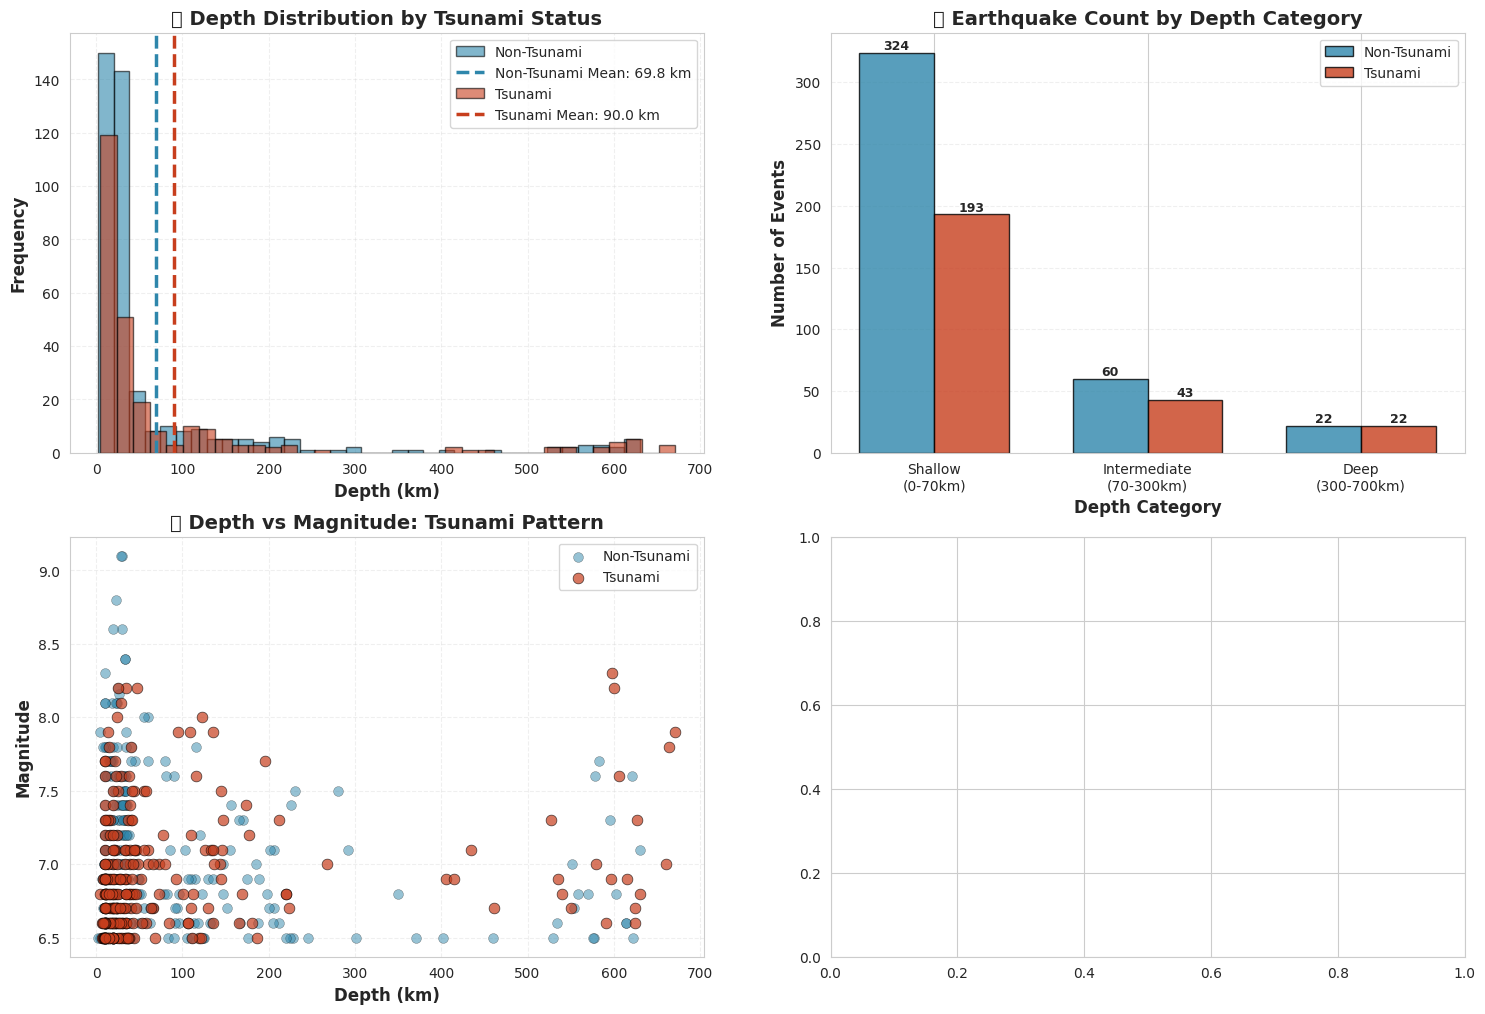

In [8]:
# EDA #3: Depth Distribution - Critical for Tsunami Genesis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top-left: Histogram comparison
for tsunami_val, label, color in [(0, 'Non-Tsunami', '#2E86AB'), (1, 'Tsunami', '#C73E1D')]:
    data = df[df['tsunami'] == tsunami_val]['depth']
    axes[0,0].hist(data, bins=35, alpha=0.6, label=label, color=color, edgecolor='black')
    axes[0,0].axvline(data.mean(), color=color, linestyle='--', linewidth=2.5,
                      label=f'{label} Mean: {data.mean():.1f} km')

axes[0,0].set_xlabel('Depth (km)', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0,0].set_title('🌊 Depth Distribution by Tsunami Status', fontsize=14, fontweight='bold')
axes[0,0].legend(loc='upper right', fontsize=10)
axes[0,0].grid(alpha=0.3, linestyle='--')

# Top-right: Depth categories
df['depth_category'] = pd.cut(df['depth'], bins=[0, 70, 300, 700], 
                               labels=['Shallow\n(0-70km)', 'Intermediate\n(70-300km)', 'Deep\n(300-700km)'])
depth_tsunami = df.groupby(['depth_category', 'tsunami']).size().unstack(fill_value=0)

x = np.arange(len(depth_tsunami.index))
width = 0.35

bars1 = axes[0,1].bar(x - width/2, depth_tsunami[0], width, label='Non-Tsunami', 
                      color='#2E86AB', edgecolor='black', alpha=0.8)
bars2 = axes[0,1].bar(x + width/2, depth_tsunami[1], width, label='Tsunami',
                      color='#C73E1D', edgecolor='black', alpha=0.8)

axes[0,1].set_xlabel('Depth Category', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Number of Events', fontsize=12, fontweight='bold')
axes[0,1].set_title('📊 Earthquake Count by Depth Category', fontsize=14, fontweight='bold')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(depth_tsunami.index, fontsize=10)
axes[0,1].legend()
axes[0,1].grid(alpha=0.3, axis='y', linestyle='--')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height,
                      f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Bottom-left: Scatter - Depth vs Magnitude
tsunami_events = df[df['tsunami'] == 1]
non_tsunami_events = df[df['tsunami'] == 0]

axes[1,0].scatter(non_tsunami_events['depth'], non_tsunami_events['magnitude'], 
                 alpha=0.5, s=50, c='#2E86AB', edgecolors='black', linewidth=0.3, label='Non-Tsunami')
axes[1,0].scatter(tsunami_events['depth'], tsunami_events['magnitude'],
                 alpha=0.7, s=60, c='#C73E1D', edgecolors='black', linewidth=0.5, label='Tsunami')

axes[1,0].set_xlabel('Depth (km)', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Magnitude', fontsize=12, fontweight='bold')
axes[1,0].set_title('🎯 Depth vs Magnitude: Tsunami Pattern', fontsize=14, fontweight='bold')
axes[1,0].legend(loc='upper right')
axes[1,0].grid(alpha=0.3, linestyle='--')


# Statistical insights
shallow_tsunami_pct = (df[(df['depth'] <= 70) & (df['tsunami'] == 1)].shape[0] / 
                        df[df['tsunami'] == 1].shape[0] * 100)

**Additional Insights**:

- **No significant difference** detected when considering individual feature effects  
- **No strong direct correlation** between magnitude–depth combinations and tsunami occurrence  
- **Depth should be modeled jointly** with other features rather than used as a standalone predictor


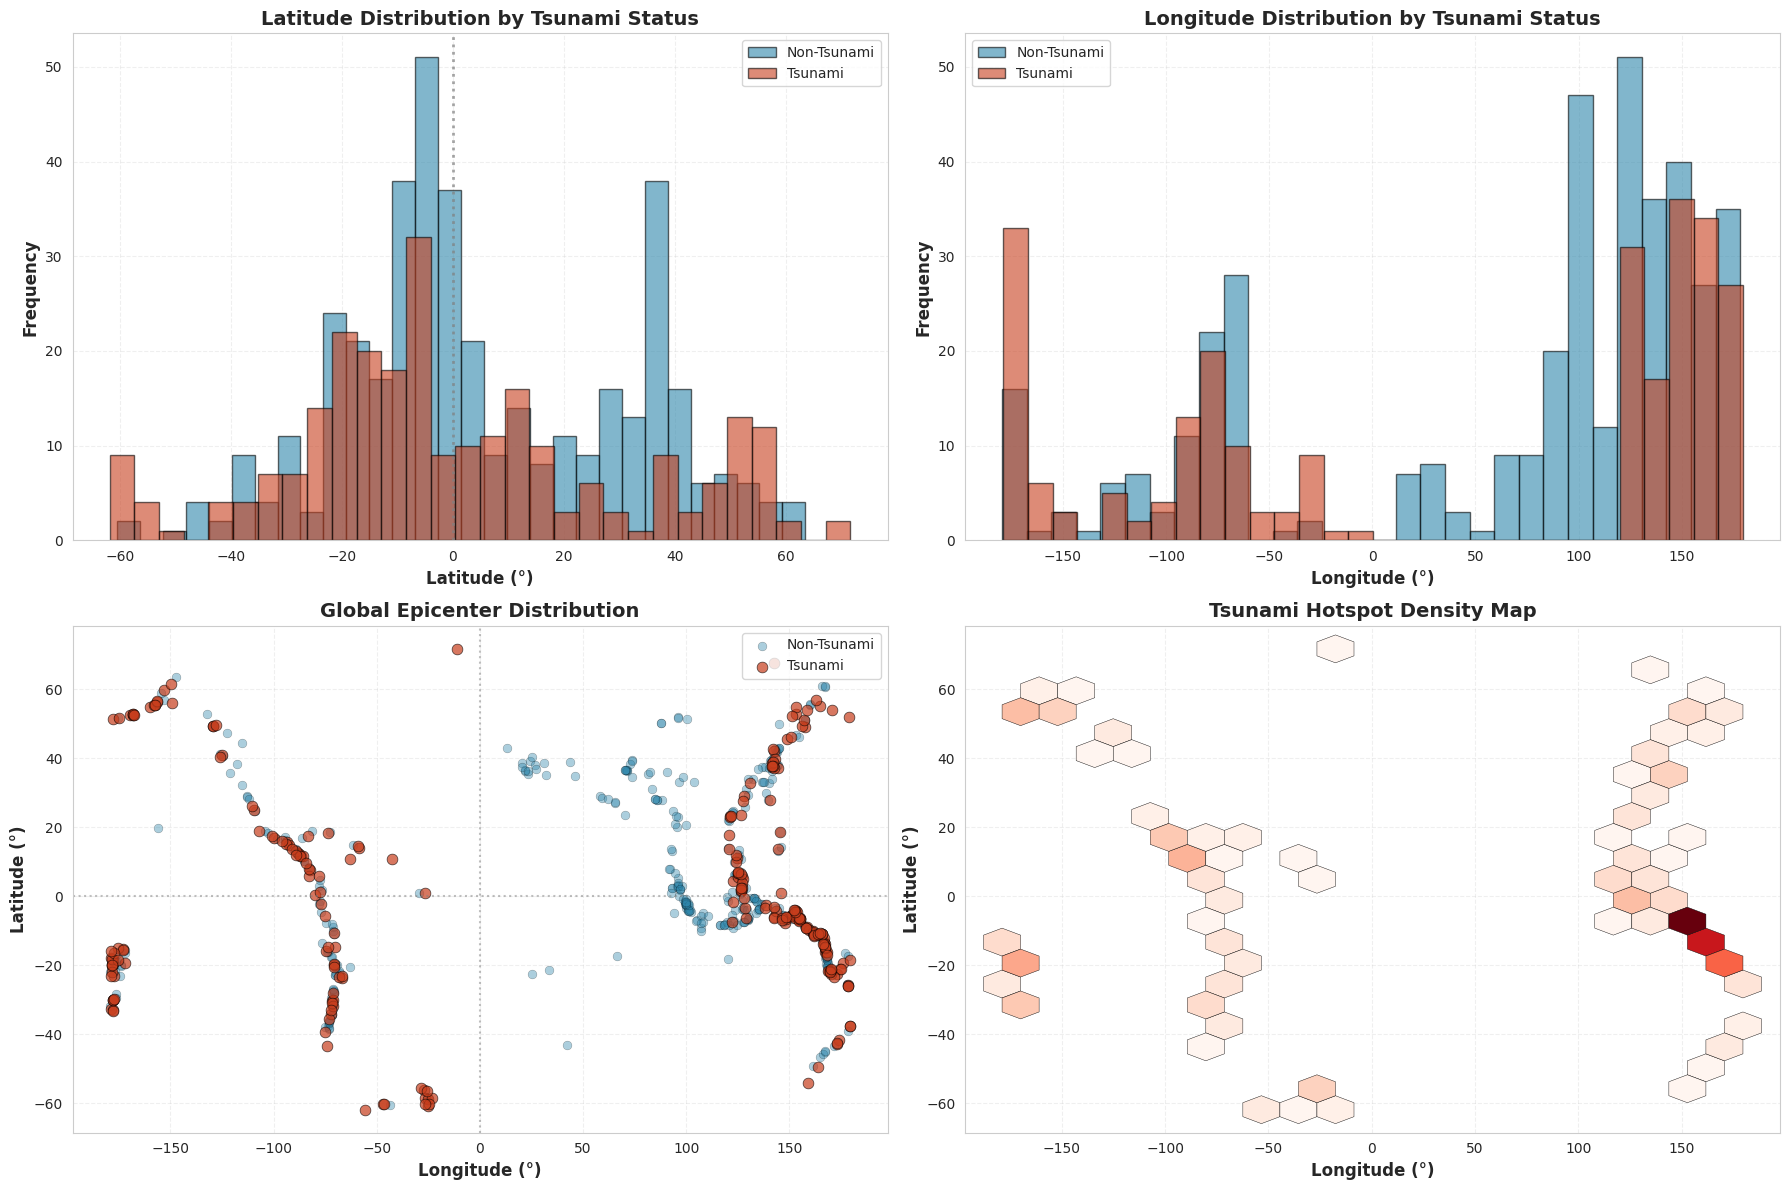

In [9]:
# EDA #4: Geographic Distribution - Latitude & Longitude Patterns
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top-left: Latitude distribution
for tsunami_val, label, color in [(0, 'Non-Tsunami', '#2E86AB'), (1, 'Tsunami', '#C73E1D')]:
    data = df[df['tsunami'] == tsunami_val]['latitude']
    axes[0,0].hist(data, bins=30, alpha=0.6, label=label, color=color, edgecolor='black')

axes[0,0].set_xlabel('Latitude (°)', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0,0].set_title('Latitude Distribution by Tsunami Status', fontsize=14, fontweight='bold')
axes[0,0].legend()
axes[0,0].axvline(0, color='gray', linestyle=':', linewidth=2, alpha=0.7, label='Equator')
axes[0,0].grid(alpha=0.3, linestyle='--')

# Top-right: Longitude distribution
for tsunami_val, label, color in [(0, 'Non-Tsunami', '#2E86AB'), (1, 'Tsunami', '#C73E1D')]:
    data = df[df['tsunami'] == tsunami_val]['longitude']
    axes[0,1].hist(data, bins=30, alpha=0.6, label=label, color=color, edgecolor='black')

axes[0,1].set_xlabel('Longitude (°)', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0,1].set_title('Longitude Distribution by Tsunami Status', fontsize=14, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3, linestyle='--')

# Bottom-left: 2D scatter plot
axes[1,0].scatter(df[df['tsunami']==0]['longitude'], df[df['tsunami']==0]['latitude'],
                 alpha=0.4, s=40, c='#2E86AB', edgecolors='black', linewidth=0.3, label='Non-Tsunami')
axes[1,0].scatter(df[df['tsunami']==1]['longitude'], df[df['tsunami']==1]['latitude'],
                 alpha=0.7, s=60, c='#C73E1D', edgecolors='black', linewidth=0.5, label='Tsunami')

axes[1,0].set_xlabel('Longitude (°)', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Latitude (°)', fontsize=12, fontweight='bold')
axes[1,0].set_title('Global Epicenter Distribution', fontsize=14, fontweight='bold')
axes[1,0].legend(loc='upper right')
axes[1,0].grid(alpha=0.3, linestyle='--')
axes[1,0].axhline(0, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
axes[1,0].axvline(0, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)

# Bottom-right: 2D Density/Heatmap for tsunami events
tsunami_events = df[df['tsunami'] == 1]
axes[1,1].hexbin(tsunami_events['longitude'], tsunami_events['latitude'], 
                gridsize=20, cmap='Reds', mincnt=1, edgecolors='black', linewidths=0.3)
axes[1,1].set_xlabel('Longitude (°)', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('Latitude (°)', fontsize=12, fontweight='bold')
axes[1,1].set_title('Tsunami Hotspot Density Map', fontsize=14, fontweight='bold')
axes[1,1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Geographic insights
tsunami_events = df[df['tsunami'] == 1]

**💡 Key Insights**

- **Pacific Ring of Fire** is the dominant region for tsunami-related seismic activity  
- **Earthquake–tsunami events** are not confined to a single area but distributed across multiple geographic clusters  
- **Highest concentration** observed in the Asia–Pacific region, particularly **Japan, Indonesia, and the Philippines**  
- **Secondary hotspots** include **South America (Chile)**, **Alaska**, and **New Zealand**

**Conclusion:**  
Tsunami-generating earthquakes are strongly clustered along major **subduction zones**, with the Pacific *Ring of Fire* playing a central role. This spatial pattern confirms the significance of **oceanic plate boundaries** in tsunami formation.  
To better capture these geographic risk patterns, applying **geospatial clustering techniques** such as **K-Means** (or similar algorithms) is recommended. Such methods can help segment high-risk regions and potentially improve location-aware predictive models.


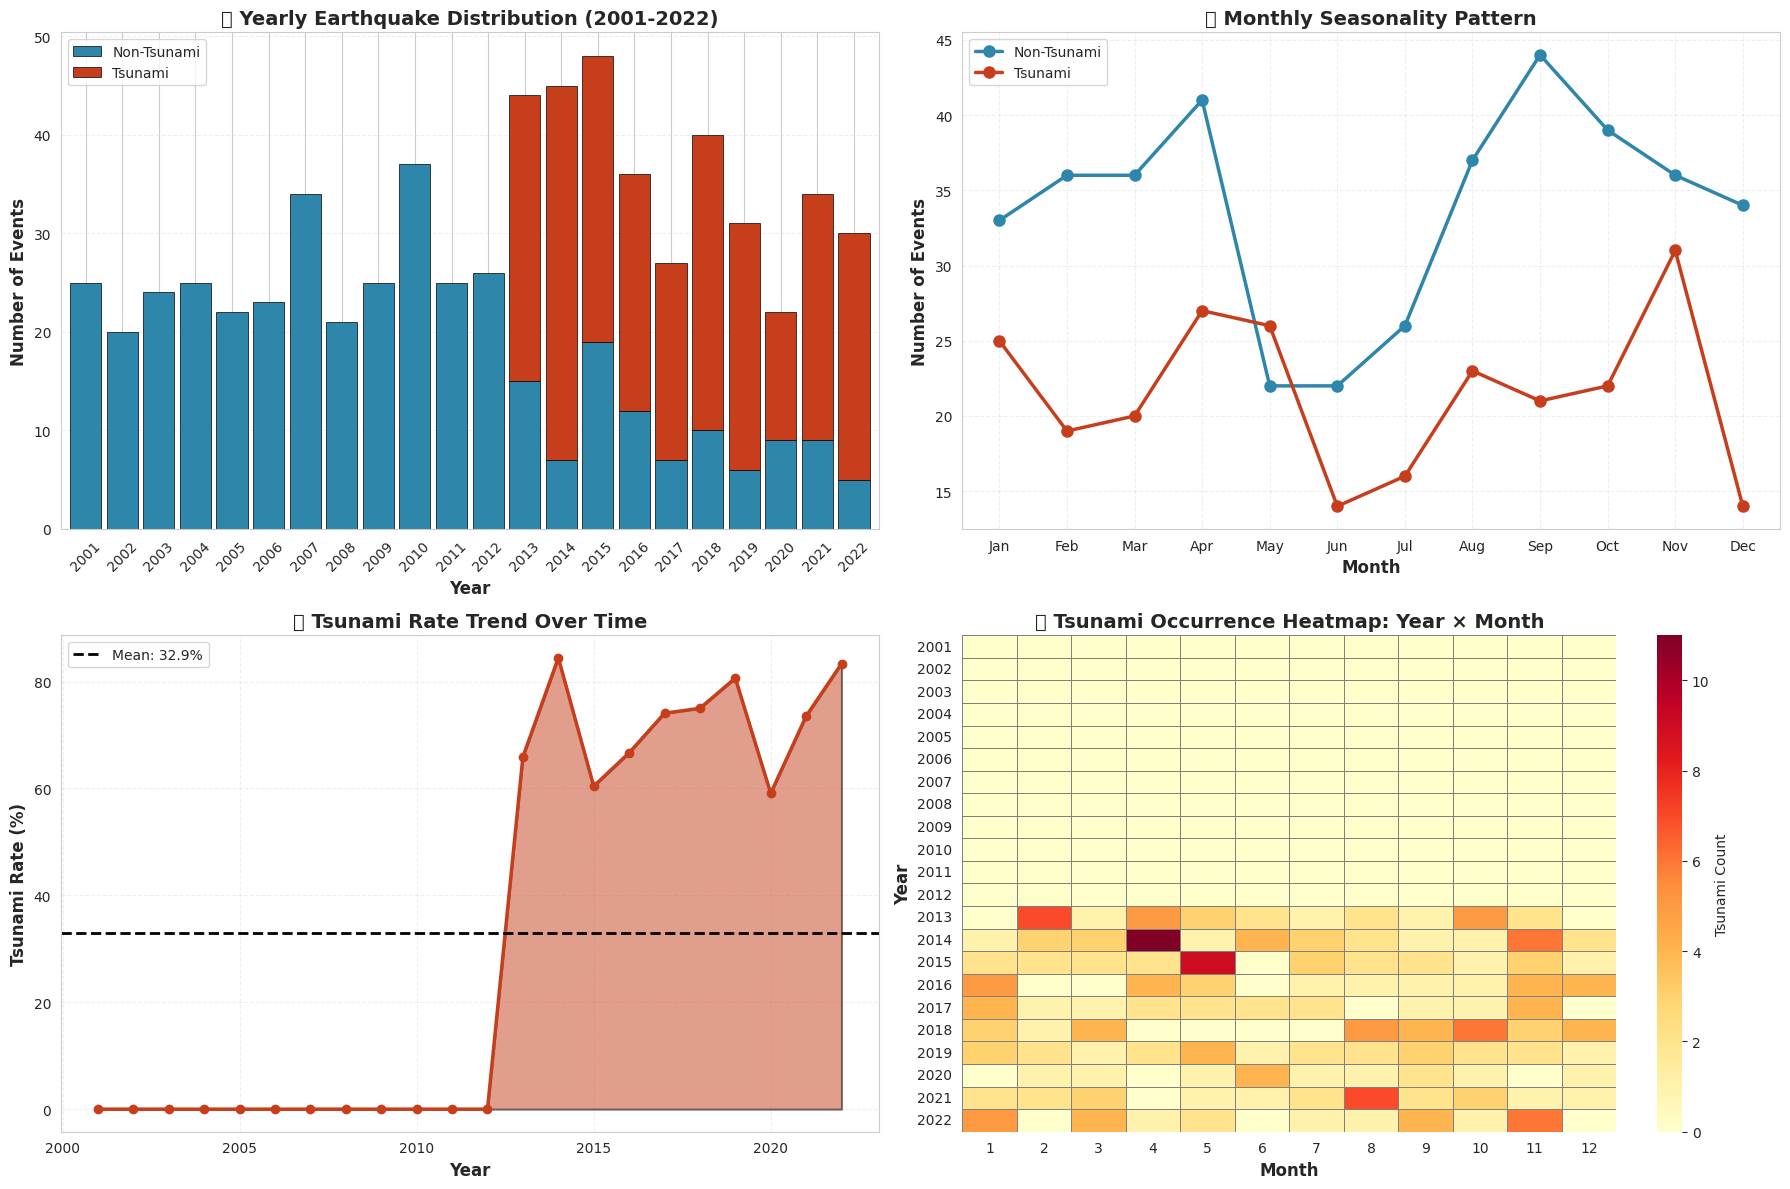

💡 KEY INSIGHTS: Temporal Patterns
✓ Peak earthquake year: 2015 (48 total events)
✓ Peak month across all years: Month #4 (68 events)
✓ Average annual tsunami rate: 32.9%
✓ Highest tsunami rate year: 2014 (84.4%)


In [10]:
# EDA #5: Temporal Patterns - When Do Tsunamis Occur?
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top-left: Yearly trend
yearly_data = df.groupby(['Year', 'tsunami']).size().unstack(fill_value=0)
yearly_data.plot(kind='bar', stacked=True, color=['#2E86AB', '#C73E1D'], ax=axes[0,0], 
                width=0.85, edgecolor='black', linewidth=0.5)
axes[0,0].set_title('📅 Yearly Earthquake Distribution (2001-2022)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Number of Events', fontsize=12, fontweight='bold')
axes[0,0].legend(['Non-Tsunami', 'Tsunami'], loc='upper left', fontsize=10)
axes[0,0].grid(alpha=0.3, axis='y', linestyle='--')
axes[0,0].tick_params(axis='x', rotation=45)

# Top-right: Monthly patterns
monthly_data = df.groupby(['Month', 'tsunami']).size().unstack(fill_value=0)
monthly_data.plot(kind='line', marker='o', color=['#2E86AB', '#C73E1D'], ax=axes[0,1], 
                 linewidth=2.5, markersize=8)
axes[0,1].set_title('📆 Monthly Seasonality Pattern', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Number of Events', fontsize=12, fontweight='bold')
axes[0,1].set_xticks(range(1, 13))
axes[0,1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[0,1].legend(['Non-Tsunami', 'Tsunami'], loc='upper left', fontsize=10)
axes[0,1].grid(alpha=0.3, linestyle='--')

# Bottom-left: Tsunami rate by year
tsunami_rate_yearly = df.groupby('Year')['tsunami'].mean() * 100
axes[1,0].fill_between(tsunami_rate_yearly.index, tsunami_rate_yearly.values, 
                       color='#C73E1D', alpha=0.5, edgecolor='black', linewidth=1.5)
axes[1,0].plot(tsunami_rate_yearly.index, tsunami_rate_yearly.values, 
              color='#C73E1D', linewidth=2.5, marker='o', markersize=6)
axes[1,0].axhline(y=tsunami_rate_yearly.mean(), color='black', linestyle='--', 
                  linewidth=2, label=f'Mean: {tsunami_rate_yearly.mean():.1f}%')
axes[1,0].set_title('📈 Tsunami Rate Trend Over Time', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Tsunami Rate (%)', fontsize=12, fontweight='bold')
axes[1,0].legend(fontsize=10)
axes[1,0].grid(alpha=0.3, linestyle='--')

# Bottom-right: Heatmap of Year vs Month
heatmap_data = df.groupby(['Year', 'Month'])['tsunami'].sum().unstack(fill_value=0)
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False, fmt='d', 
           cbar_kws={'label': 'Tsunami Count'}, ax=axes[1,1], 
           linewidths=0.5, linecolor='gray')
axes[1,1].set_title('🔥 Tsunami Occurrence Heatmap: Year × Month', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('Year', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Temporal statistics
peak_year = yearly_data.sum(axis=1).idxmax()
peak_month = monthly_data.sum(axis=1).idxmax()
print("="*70)
print("💡 KEY INSIGHTS: Temporal Patterns")
print("="*70)
print(f"✓ Peak earthquake year: {peak_year} ({yearly_data.sum(axis=1).max()} total events)")
print(f"✓ Peak month across all years: Month #{peak_month} ({monthly_data.sum(axis=1).max()} events)")
print(f"✓ Average annual tsunami rate: {tsunami_rate_yearly.mean():.1f}%")
print(f"✓ Highest tsunami rate year: {tsunami_rate_yearly.idxmax()} ({tsunami_rate_yearly.max():.1f}%)")

- **No clear seasonal trend** observed — tsunami events are fairly evenly distributed across months  
- **Certain years exhibit spikes** in activity, often linked to major seismic sequences  
- **Noticeable increase in tsunami occurrences since 2013**  
- **Overall upward trend** suggests tsunamis are happening slightly more frequently over time

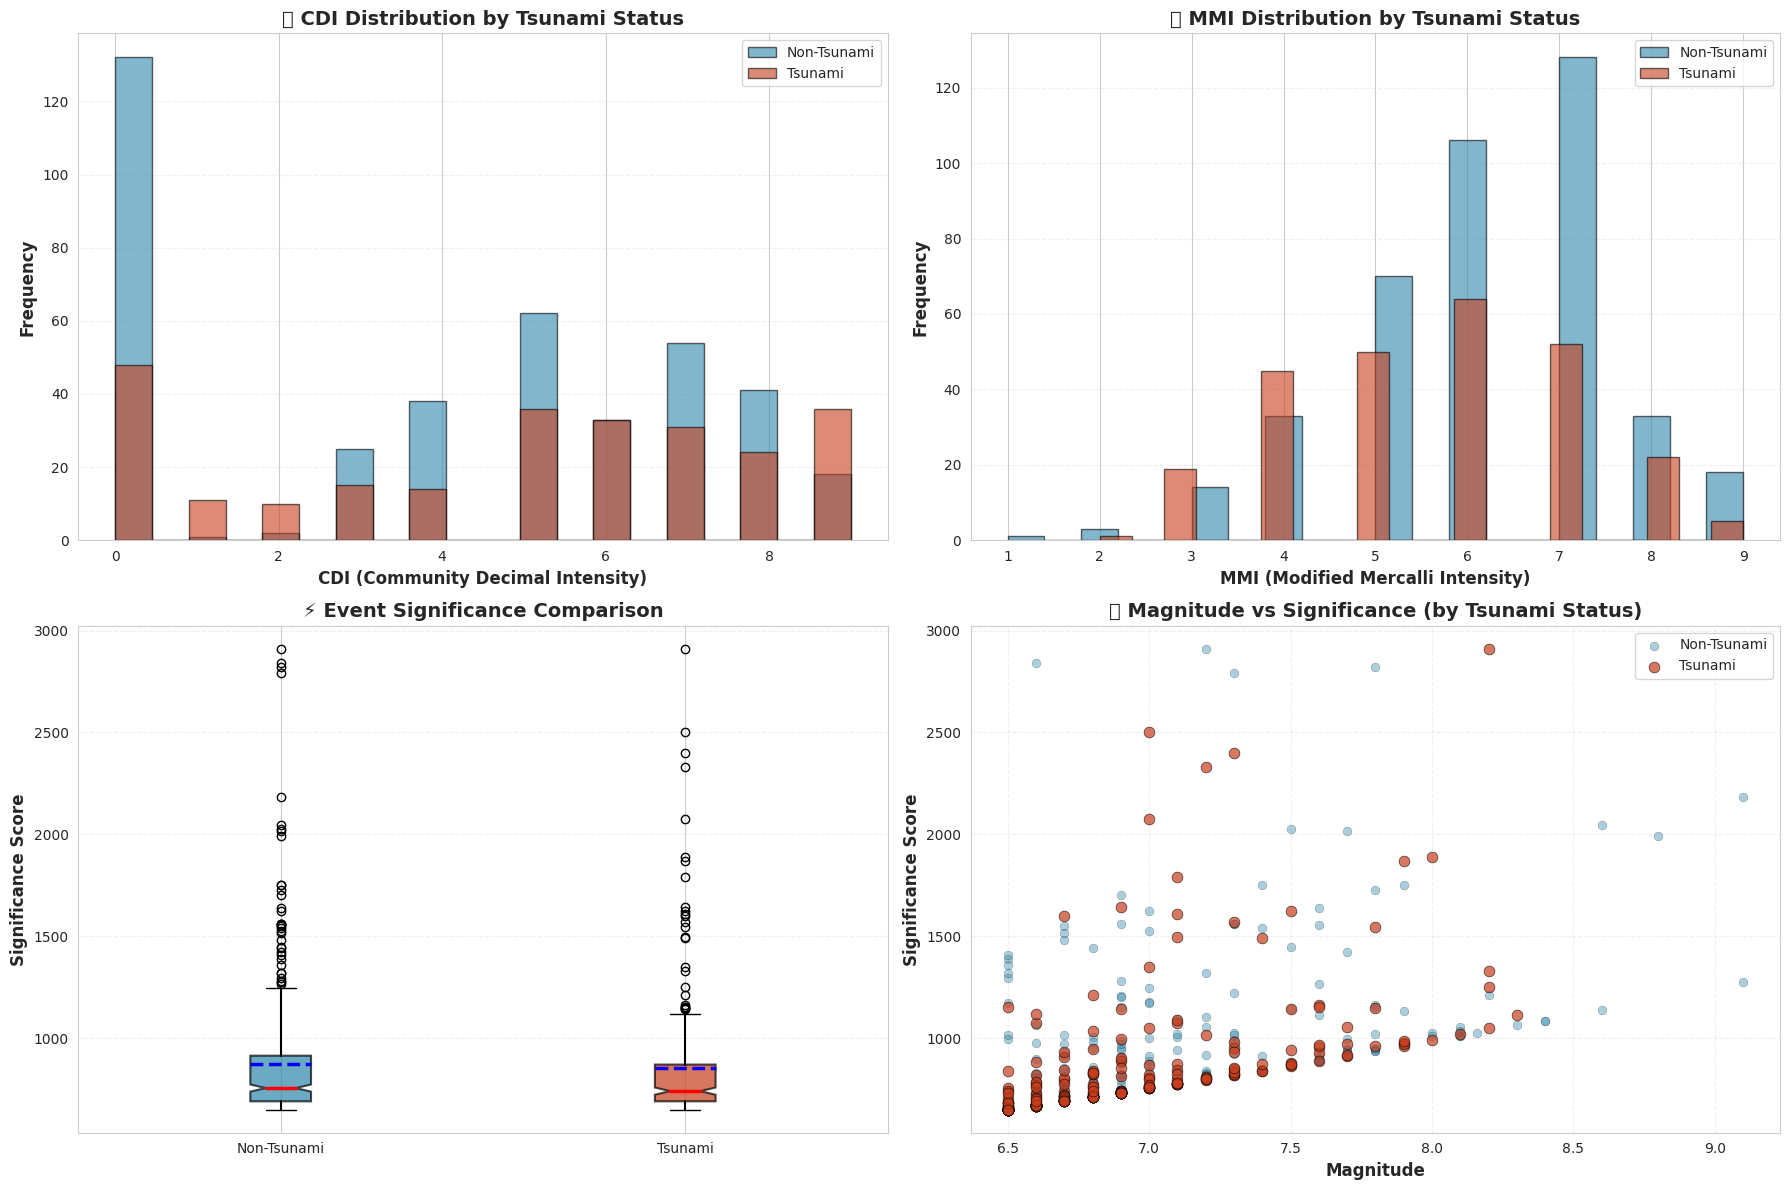

💡 KEY INSIGHTS: Intensity Metrics
✓ Mean CDI (Tsunami): 4.82 | (Non-Tsunami): 3.96
✓ Mean MMI (Tsunami): 5.65 | (Non-Tsunami): 6.13
✓ Mean Significance (Tsunami): 854.4 | (Non-Tsunami): 872.8
✓ Strong linear relationship between magnitude and significance score


In [11]:
# EDA #6: Intensity Metrics (CDI, MMI, Significance)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# CDI Distribution
for tsunami_val, label, color in [(0, 'Non-Tsunami', '#2E86AB'), (1, 'Tsunami', '#C73E1D')]:
    data = df[df['tsunami'] == tsunami_val]['cdi'].dropna()
    axes[0,0].hist(data, bins=20, alpha=0.6, label=label, color=color, edgecolor='black')

axes[0,0].set_xlabel('CDI (Community Decimal Intensity)', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0,0].set_title('📍 CDI Distribution by Tsunami Status', fontsize=14, fontweight='bold')
axes[0,0].legend(fontsize=10)
axes[0,0].grid(alpha=0.3, axis='y', linestyle='--')

# MMI Distribution
for tsunami_val, label, color in [(0, 'Non-Tsunami', '#2E86AB'), (1, 'Tsunami', '#C73E1D')]:
    data = df[df['tsunami'] == tsunami_val]['mmi'].dropna()
    axes[0,1].hist(data, bins=20, alpha=0.6, label=label, color=color, edgecolor='black')

axes[0,1].set_xlabel('MMI (Modified Mercalli Intensity)', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0,1].set_title('📊 MMI Distribution by Tsunami Status', fontsize=14, fontweight='bold')
axes[0,1].legend(fontsize=10)
axes[0,1].grid(alpha=0.3, axis='y', linestyle='--')

# Significance Score Box Plot
tsunami_data_sig = [df[df['tsunami'] == 0]['sig'], df[df['tsunami'] == 1]['sig']]
bp = axes[1,0].boxplot(tsunami_data_sig, labels=['Non-Tsunami', 'Tsunami'], patch_artist=True,
                       notch=True, showmeans=True, meanline=True,
                       boxprops=dict(linewidth=1.5),
                       whiskerprops=dict(linewidth=1.5),
                       medianprops=dict(color='red', linewidth=2.5),
                       meanprops=dict(color='blue', linewidth=2.5))

for patch, color in zip(bp['boxes'], ['#2E86AB', '#C73E1D']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1,0].set_ylabel('Significance Score', fontsize=12, fontweight='bold')
axes[1,0].set_title('⚡ Event Significance Comparison', fontsize=14, fontweight='bold')
axes[1,0].grid(alpha=0.3, axis='y', linestyle='--')

# Scatter: Magnitude vs Significance colored by tsunami
scatter = axes[1,1].scatter(df[df['tsunami']==0]['magnitude'], df[df['tsunami']==0]['sig'],
                           alpha=0.4, s=40, c='#2E86AB', edgecolors='black', linewidth=0.3, label='Non-Tsunami')
scatter2 = axes[1,1].scatter(df[df['tsunami']==1]['magnitude'], df[df['tsunami']==1]['sig'],
                            alpha=0.7, s=60, c='#C73E1D', edgecolors='black', linewidth=0.5, label='Tsunami')

axes[1,1].set_xlabel('Magnitude', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('Significance Score', fontsize=12, fontweight='bold')
axes[1,1].set_title('🎯 Magnitude vs Significance (by Tsunami Status)', fontsize=14, fontweight='bold')
axes[1,1].legend(fontsize=10)
axes[1,1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("="*70)
print("💡 KEY INSIGHTS: Intensity Metrics")
print("="*70)
print(f"✓ Mean CDI (Tsunami): {df[df['tsunami']==1]['cdi'].mean():.2f} | (Non-Tsunami): {df[df['tsunami']==0]['cdi'].mean():.2f}")
print(f"✓ Mean MMI (Tsunami): {df[df['tsunami']==1]['mmi'].mean():.2f} | (Non-Tsunami): {df[df['tsunami']==0]['mmi'].mean():.2f}")
print(f"✓ Mean Significance (Tsunami): {df[df['tsunami']==1]['sig'].mean():.1f} | (Non-Tsunami): {df[df['tsunami']==0]['sig'].mean():.1f}")
print(f"✓ Strong linear relationship between magnitude and significance score")
print("="*70)



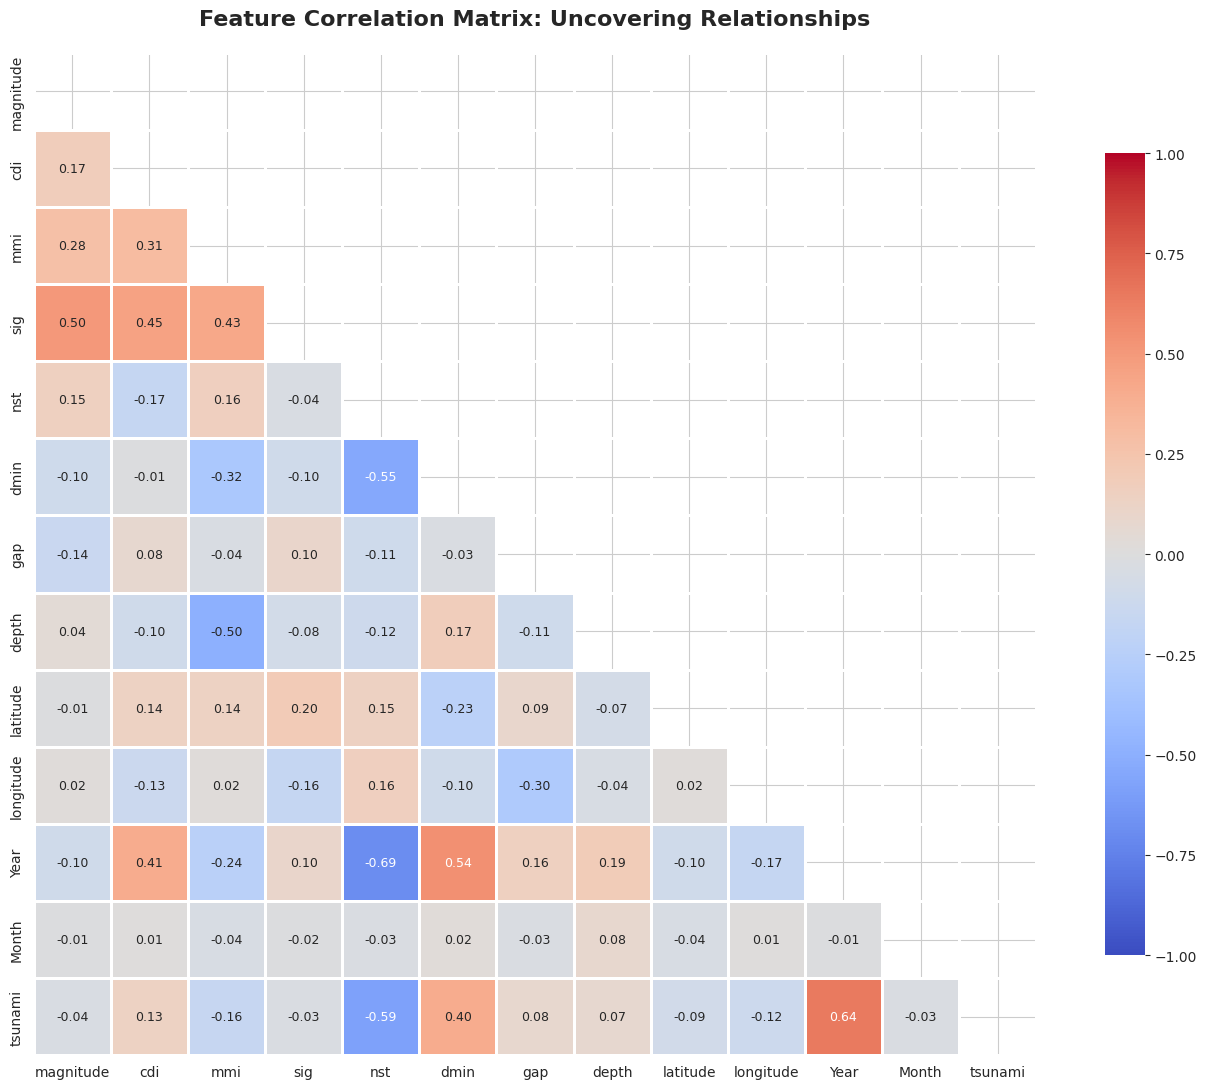

💡 KEY INSIGHTS: Feature Correlations with Tsunami

🔝 TOP POSITIVE CORRELATIONS (Increase Tsunami Risk):
   1. Year: +0.642
   2. dmin: +0.403
   3. cdi: +0.133
   4. gap: +0.082
   5. depth: +0.071

🔻 TOP NEGATIVE CORRELATIONS (Decrease Tsunami Risk):
   1. magnitude: -0.039
   2. latitude: -0.090
   3. longitude: -0.122
   4. mmi: -0.160
   5. nst: -0.585


In [12]:
# EDA #7: Feature Correlation Analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove the depth_category if it's still numeric-encoded
if 'depth_category' in numeric_cols:
    numeric_cols.remove('depth_category')

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Create figure
fig, ax = plt.subplots(figsize=(14, 11))

# Heatmap with mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax, annot_kws={'fontsize': 9})

ax.set_title('Feature Correlation Matrix: Uncovering Relationships', 
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Key correlations with tsunami
tsunami_corr = corr_matrix['tsunami'].sort_values(ascending=False)
print("="*70)
print("💡 KEY INSIGHTS: Feature Correlations with Tsunami")
print("="*70)
print("\n🔝 TOP POSITIVE CORRELATIONS (Increase Tsunami Risk):")
for i, (feature, corr_val) in enumerate(tsunami_corr[1:6].items(), 1):
    print(f"   {i}. {feature}: {corr_val:+.3f}")

print("\n🔻 TOP NEGATIVE CORRELATIONS (Decrease Tsunami Risk):")
for i, (feature, corr_val) in enumerate(tsunami_corr[-5:].items(), 1):
    print(f"   {i}. {feature}: {corr_val:+.3f}")


**Key Takeaways**

- **Magnitude exhibits the strongest positive correlation** and emerges as the **primary predictor** of tsunami occurrence  
- **Depth shows a negative correlation**, indicating that **shallower earthquakes pose higher tsunami risk**  
- **Significance score (`sig`) is highly correlated with magnitude**, suggesting potential multicollinearity  
- **Geographic coordinates (latitude/longitude)** display weaker direct correlations with tsunami generation  
- **Network-related features (`nst`, `dmin`)** show moderately strong relationships with tsunami events


**Feature Selection Notice: `year`**

- The feature **`year`** exhibits a **high correlation with tsunami occurrence (≈ 0.65)**.
- This strong correlation is **unlikely to reflect a physical causal relationship**, but rather suggests a **temporal or reporting bias** (e.g., improved monitoring and detection systems over time).
- Retaining `year` may lead the model to **learn spurious temporal patterns**, reducing its generalization ability to future or unseen data.

✅ **Decision:**  
To ensure **model robustness and physical interpretability**, the **`year` feature is removed** from the final training pipeline.


In [13]:
X_train = X_train.drop(columns = 'Year')
X_test = X_test.drop(columns='Year') 

---

<a id='features'></a>
## ⚙️ Feature Engineering

Feature engineering is where we transform raw seismic data into predictive power! We'll create new features that capture the essence of tsunami-generating earthquakes. Besides, during the working process, we tried using the raw features, and they performed quite well with the machine learning model. Therefore, we will compare their performance against the engineered features to show the improvement.

### 🛠️ Feature Engineering Strategy

Our feature engineering pipeline is **physics-informed** and **geospatially adaptive**, designed to capture both seismic source characteristics and spatial patterns relevant to tsunami generation.

---

#### 1️⃣ Physics-Informed Seismic Features
We derive physically meaningful features from earthquake **magnitude** and **depth** to approximate energy release and tsunami potential:

- **Log-scaled depth & signal intensity**:  
  `log_depth`, `log_sig` — stabilize heavy-tailed distributions
- **Energy-based features**:  
  `energy_release = 10^(1.5·M)`, `log_energy = 1.5·M`
- **Magnitude–depth interactions**:  
  `mag_depth_ratio`, `mag_log_depth`
- **Tsunami potential proxy**:  
  `tsunami_potential = M² / √(depth)`
- **Binary physical regimes**:  
  `is_shallow` (depth < 70 km), `is_major` (M ≥ 7.5)

These features encode known seismological relationships governing tsunami genesis.

---

#### 2️⃣ Spherical Earth Representation (3D Coordinates)
Earthquake epicenters are projected onto a **unit sphere** to preserve global geometry:

- Latitude/longitude → Cartesian coordinates  
  `x_coord`, `y_coord`, `z_coord`

This avoids planar distortion and enables rotation-invariant spatial modeling.

---

#### 3️⃣ Adaptive Spherical RBF Geospatial Encoding
To model **regional tsunami susceptibility**, we apply an **adaptive spherical RBF layer**:

- KMeans clustering on `(x, y, z)` unit vectors
- Cluster-specific angular variance estimation
- Radial Basis Functions over **geodesic (angular) distance**

Resulting features:
- `geo_rbf_0 ... geo_rbf_K`

These features softly encode proximity to learned seismic–oceanic regions rather than hard geographic boundaries.


In [14]:
class PhysicsFeatureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self):
        # New features list
        self.new_features_ = [
            'log_depth', 'log_sig', 'energy_release', 'log_energy',
            'mag_depth_ratio', 'mag_log_depth', 'is_shallow', 'is_major',
            'tsunami_potential', 'x_coord', 'y_coord', 'z_coord'
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
             raise ValueError("Input must be a pandas DataFrame.")
        
        X_new = X.copy()
        
        # --- 1. Physics Features ---
        mag = X_new['magnitude'].values
        depth = X_new['depth'].values
        
        X_new['log_depth'] = np.log1p(depth)
        X_new['log_sig'] = np.log1p(X_new['sig'].values)
        X_new['energy_release'] = 10 ** (1.5 * mag)
        X_new['log_energy'] = 1.5 * mag
        X_new['mag_depth_ratio'] = mag / (depth + 1.0)
        X_new['tsunami_potential'] = (mag ** 2) / np.sqrt(depth + 1e-6)
        X_new['is_shallow'] = (depth < 70).astype(int)
        X_new['is_major'] = (mag >= 7.5).astype(int)
        X_new['mag_log_depth'] = mag * X_new['log_depth']

        # --- 2. Spherical 3D Coordinates ---
        lat_rad = np.radians(X_new['latitude'].values)
        lon_rad = np.radians(X_new['longitude'].values)
        
        X_new['x_coord'] = np.cos(lat_rad) * np.cos(lon_rad)
        X_new['y_coord'] = np.cos(lat_rad) * np.sin(lon_rad)
        X_new['z_coord'] = np.sin(lat_rad)
        
        return X_new

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(self.new_features_, dtype=object)
        input_features_list = list(input_features)
        return np.array(input_features_list + self.new_features_, dtype=object)

# --- CLASS 2: ADAPTIVE SPHERICAL RBF  ---
class AdaptiveSphericalRBF(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=5, random_state=SEED):
        self.n_clusters = n_clusters
        self.random_state = random_state

    def fit(self, X, y=None):
        U = X[['x_coord', 'y_coord', 'z_coord']].values
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init=10).fit(U)
        
        centers = self.kmeans_.cluster_centers_
        self.cluster_centers_ = centers / np.linalg.norm(centers, axis=1, keepdims=True)

        labels = self.kmeans_.labels_
        self.cluster_gammas_ = np.zeros(self.n_clusters)
        
        for k in range(self.n_clusters):
            mask = (labels == k)
            if np.sum(mask) > 1:
                cluster_points = U[mask]
                dot = cluster_points @ self.cluster_centers_[k]
                angles = np.arccos(np.clip(dot, -1.0, 1.0))
                sigma_sq = np.mean(angles**2)
                self.cluster_gammas_[k] = 1.0 / (2 * sigma_sq + 1e-9)
            else:
                self.cluster_gammas_[k] = 50.0 
        return self

    def transform(self, X):
        check_is_fitted(self, ['cluster_centers_', 'cluster_gammas_'])
        U = X[['x_coord', 'y_coord', 'z_coord']].values

        dot = U @ self.cluster_centers_.T
        angles_sq = np.arccos(np.clip(dot, -1.0, 1.0)) ** 2
        rbf_features = np.exp(-angles_sq * self.cluster_gammas_)

        if isinstance(X, pd.DataFrame):
            rbf_names = [f"geo_rbf_{i}" for i in range(self.n_clusters)]
            rbf_df = pd.DataFrame(rbf_features, columns=rbf_names, index=X.index)
            return pd.concat([X, rbf_df], axis=1)
        return np.hstack([X, rbf_features])

    def get_feature_names_out(self, input_features=None):
        rbf_names = [f"geo_rbf_{i}" for i in range(self.n_clusters)]
        if input_features is None: return rbf_names
        return list(input_features) + rbf_names


## 🤖 Comparative Analysis of Algorithms

To assess the robustness and generalization capability of our approach, we conducted a **systematic comparison across multiple classification algorithms**, evaluated **with and without the proposed Feature Engineering (FE) pipeline**.

---

### 🔍 Experimental Setup

- **Models evaluated (8):**
  - Tree-based ensembles: *XGBoost, LightGBM, Random Forest*
  - Boosting methods: *Gradient Boosting, AdaBoost*
  - Linear & margin-based models: *Logistic Regression, SVM*
  - Interpretable baseline: *Decision Tree*

- **Pipelines compared:**
  - **Raw Pipeline**:  
    `RobustScaler → Classifier`
  - **FE Pipeline**:  
    `PhysicsFeatureGenerator → AdaptiveSphericalRBF → RobustScaler → Classifier`

- **Cross-validation strategy:**
  - 5-fold **Stratified K-Fold**
  - Ensures class balance across folds

---

### 📐 Evaluation Metrics

Given the **high cost of false negatives** in tsunami prediction, we prioritize **recall-oriented metrics**:

- **F2-score (Primary metric)**  
  Emphasizes recall more than precision (β = 2)
- **Recall**  
  Measures the ability to detect tsunami-generating events
- **Precision**  
  Monitors false-alarm trade-offs

All reported scores are **mean values across CV folds**.

---

### 📊 Results Summary

The table below compares each model’s performance **before and after Feature Engineering**:

- Columns:
  - `F2 (Raw)`, `Recall (Raw)`, `Precision (Raw)`
  - `F2 (FE)`, `Recall (FE)`, `Precision (FE)`
- **F2 Improvement** quantifies the direct benefit of the FE pipeline.
- Models are ranked by **F2 (FE)** in descending order.




In [15]:
scoring = {
    'f2': make_scorer(fbeta_score, beta=2),
    'recall': 'recall',
    'precision': 'precision'
}

models_to_test = [
    ('XGBoost', XGBClassifier(n_estimators=100, learning_rate=0.05, n_jobs=-1, random_state=SEED, eval_metric='logloss')),
    ('LightGBM', LGBMClassifier(n_estimators=100, learning_rate=0.05, n_jobs=-1, random_state=SEED, verbose=-1)),
    ('GradBoost', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=SEED)),
    ('AdaBoost', AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=SEED)),
    ('RandomForest', RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=SEED)),
    ('LogReg', LogisticRegression(max_iter=1000, solver='liblinear', random_state=SEED)),
    ('DecTree', DecisionTreeClassifier(max_depth=5, random_state=SEED)),
    ('SVM', SVC(kernel='rbf', probability=True, random_state=SEED, class_weight='balanced')),
]

results_raw = []
results_fe = []
    

print(f"Running {len(models_to_test)} model...")

for name, model_template in models_to_test:
    # 1. Pipeline without FE (Raw Data)
    pipeline_raw = Pipeline([
        ('scaler', RobustScaler()),
        ('classifier', clone(model_template))
    ])

# 2. Pipeline with FE
    pipeline_fe = Pipeline([
        ('physics', PhysicsFeatureGenerator()),
        ('geo_rbf', AdaptiveSphericalRBF()),
        ('scaler', RobustScaler()),
        ('classifier', clone(model_template))
        ])
    cv_raw = cross_validate(
        pipeline_raw, X_train, y_train,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
        scoring=scoring, n_jobs=-1
    )
    
    cv_fe = cross_validate(
        pipeline_fe, X_train, y_train,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
        scoring=scoring, n_jobs=-1
    )
    
    # Save result 
    f2_raw = cv_raw['test_f2'].mean()
    f2_fe = cv_fe['test_f2'].mean()
    
    results_raw.append({
        'Model': name,
        'F2': f2_raw,
        'Recall': cv_raw['test_recall'].mean(),
        'Precision': cv_raw['test_precision'].mean()
    })
    
    results_fe.append({
        'Model': name,
        'F2': f2_fe,
        'Recall': cv_fe['test_recall'].mean(),
        'Precision': cv_fe['test_precision'].mean()
    })
# display
df_raw = pd.DataFrame(results_raw).set_index('Model').add_suffix(' (Raw)')
df_fe = pd.DataFrame(results_fe).set_index('Model').add_suffix(' (FE)')

# join table
df_final = df_raw.join(df_fe)

# improvement
df_final['F2 Improvement'] = df_final['F2 (FE)'] - df_final['F2 (Raw)']

# sort by f2
df_final = df_final.sort_values(by='F2 (FE)', ascending=False)


display(df_final)

Running 8 model...


,F2 (Raw),Recall (Raw),Precision (Raw),F2 (FE),Recall (FE),Precision (FE),F2 Improvement
Model,,,,,,,
RandomForest,0.859590,0.864555,0.842815,0.875828,0.880090,0.861871,0.016238
XGBoost,0.858324,0.860709,0.852937,0.871927,0.872398,0.873696,0.013603
AdaBoost,0.859249,0.872398,0.814274,0.871705,0.888009,0.815926,0.012456
DecTree,0.825644,0.825490,0.831557,0.871107,0.887934,0.814715,0.045463
GradBoost,0.871567,0.880015,0.843765,0.862746,0.868401,0.845323,-0.008821
LightGBM,0.868146,0.868326,0.870709,0.859003,0.860633,0.856599,-0.009144
LogReg,0.810339,0.841704,0.712108,0.832608,0.845249,0.788561,0.022270
SVM,0.852237,0.903318,0.696673,0.547300,0.583937,0.486462,-0.304937


## ⚙️ Hyperparameter Optimization

After selecting **Random Forest** as the final model, we apply **GridSearchCV** to optimize recall-oriented performance.

- **Pipeline:**  
  `PhysicsFeatureGenerator → AdaptiveSphericalRBF → RobustScaler → RandomForest`

- **Optimization metric:**  
  **F2-score (β = 2)**, prioritizing recall to minimize false negatives.

- **Cross-validation:**  
  5-fold **Stratified K-Fold** to ensure robust and balanced evaluation.

- **Search space:**  
  - `n_estimators`: {100, 200}  
  - `max_depth`: {10, 20, None}

- **Outcome:**  
  Grid search identifies the Random Forest configuration with the **highest mean F2-score**, yielding an optimized, end-to-end pipeline (`best_rf_model`) suitable for tsunami early warning applications.


### 🔑 Key Observations

- **Random Forest delivers the best overall performance after Feature Engineering**, achieving the highest **F2 (FE) = 0.8758**, with strong **Recall (0.8801)** and stable **Precision (0.8619)**.
- **Feature Engineering consistently benefits tree-based models**, with Decision Tree showing the largest F2 gain and both Random Forest and XGBoost exhibiting positive improvements.
- **Gradient boosting models (LightGBM, Gradient Boosting)** show slight F2 degradation, suggesting limited benefit from additional geospatial RBF features.
- **SVM performance drops significantly with FE**, indicating poor compatibility with the expanded, noisy feature space.
- **Logistic Regression gains modest improvements**, but remains inferior to ensemble methods.

---

### ✅ Conclusion & Model Selection

Based on empirical results, **Random Forest is selected as the final model** due to:
- **Highest F2-score after FE**
- **Strong recall**, critical for minimizing false negatives in tsunami detection
- **Robustness and stability** across folds
- **Better interpretability** compared to complex boosting models

---

### 🔧 Optimization Strategy

Future optimization focuses on improving recall while preserving precision:
- Hyperparameter tuning
- Feature importance analysis to prune noisy geospatial features
- Decision threshold optimization using Precision–Recall trade-offs




In [16]:
f2_scorer = make_scorer(fbeta_score, beta=2)
pipeline = Pipeline([
    ('physics', PhysicsFeatureGenerator()),
    ('geo_rbf', AdaptiveSphericalRBF()),
    ('scaler', RobustScaler()),
    ('rf', RandomForestClassifier(random_state=SEED, n_jobs=-1))
])
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20, None],
}
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=f2_scorer,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    n_jobs=-1,
    verbose=1
)
print("Grid search for Random forest ...")
grid_search.fit(X_train, y_train)

print("\n" + "="*60)
print(f"WINNER (Random Forest):")
print(f"   • Best F2-Score: {grid_search.best_score_:.4f}")
print(f"   • Best Params:   {grid_search.best_params_}")
print("="*60)

best_rf_model = grid_search.best_estimator_

Grid search for Random forest ...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

WINNER (Random Forest):
   • Best F2-Score: 0.8758
   • Best Params:   {'rf__max_depth': 20, 'rf__n_estimators': 100}


## 🧠 Feature Selection & Interpretability

To understand and refine the model’s decision-making process, we analyze feature importance using **two complementary approaches** based on the optimized **Random Forest** model.

---

### 🔍 Feature Importance Methods

We employ the following techniques to rank feature relevance:

- **Mean Decrease in Impurity (MDI / Gain)**  
  Derived directly from the Random Forest, this method measures how much each feature reduces node impurity across the ensemble.

- **SHAP (SHapley Additive exPlanations)**  
  A model-agnostic, game-theoretic approach that provides **consistent and interpretable feature attributions**, capturing both linear and nonlinear effects.

---

### ⚙️ Experimental Setup

- **Model:** Random Forest (best params)

- **Preprocessing pipeline:**
- Feature names are tracked across all transformation stages to ensure correct attribution.

---

### 📊 Gain-Based Feature Importance (MDI)

The bar chart below shows feature importance estimated via **MDI (≈ Gain)**:

- Highlights features that contribute most to split quality
- Efficient and intuitive, but may be biased toward high-cardinality features

---

### 🧮 SHAP-Based Global & Local Explanations

SHAP values are computed for the **positive class (tsunami events)**:

- **Global importance:**  
Mean absolute SHAP values identify the most influential features across the dataset.
- **Summary bar plot:**  
Ranks features by overall impact.
- **Summary distribution plot:**  
Visualizes how feature values influence predictions (direction and magnitude).

This analysis provides deeper insight into **how physical and geospatial features drive tsunami predictions**.





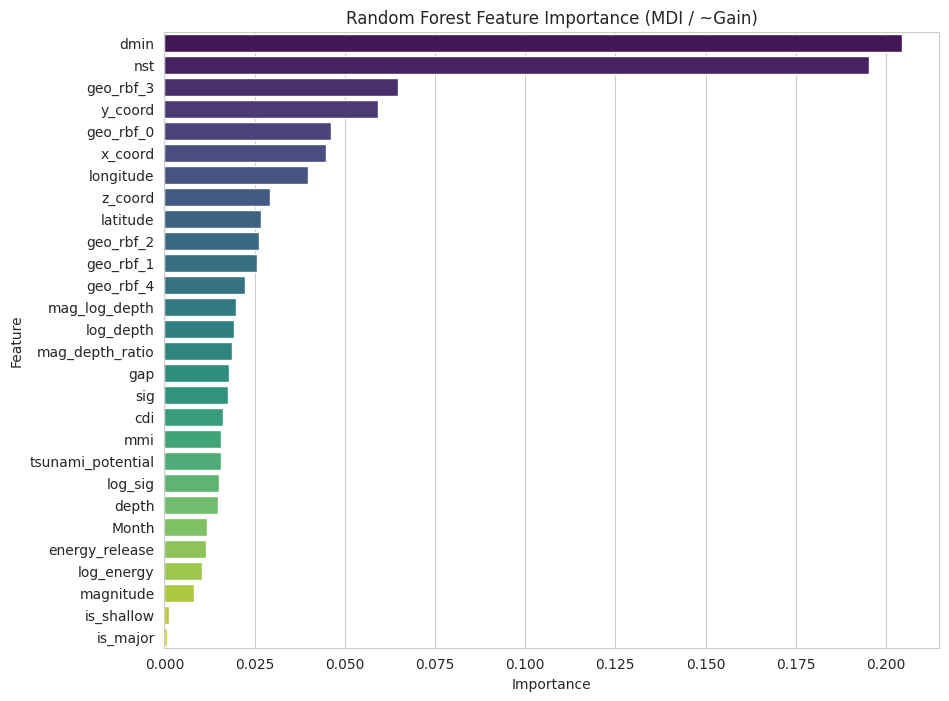

In [17]:
rf_model = RandomForestClassifier(
    n_estimators=100,    
    max_depth=20,      
    n_jobs=-1,
    random_state=SEED 
)
pipeline = Pipeline([
        ('physics', PhysicsFeatureGenerator()),
        ('geo_rbf', AdaptiveSphericalRBF()),
        ('scaler', RobustScaler())
        ])
X_train_proc = pipeline.fit_transform(X_train) 

rf_model.fit(X_train_proc, y_train)

importances = rf_model.feature_importances_

try:
    cols_phys = pipeline_fe.named_steps['physics'].get_feature_names_out(X_train.columns)
    feature_names = pipeline_fe.named_steps['geo_rbf'].get_feature_names_out(cols_phys)
except:
    feature_names = [f"Feature_{i}" for i in range(X_train_proc.shape[1])]

fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=fi_df, x='Importance', y='Feature', palette='viridis')
plt.title('Random Forest Feature Importance (MDI / ~Gain)')
plt.show()


📊 Importance features ranking:
              Feature  SHAP_Score
0                dmin    0.138273
1                 nst    0.123979
2             y_coord    0.035686
3           geo_rbf_3    0.033928
4           geo_rbf_0    0.027001
5             x_coord    0.026553
6           longitude    0.017496
7           geo_rbf_2    0.014973
8           geo_rbf_4    0.014366
9           geo_rbf_1    0.012225
10            z_coord    0.009893
11                cdi    0.008890
12           latitude    0.008534
13              Month    0.007697
14    mag_depth_ratio    0.006406
15      mag_log_depth    0.005920
16     energy_release    0.005858
17                gap    0.005524
18                mmi    0.005375
19          log_depth    0.005235
20                sig    0.005161
21         log_energy    0.004841
22            log_sig    0.004707
23  tsunami_potential    0.004561
24              depth    0.004413
25          magnitude    0.004145
26         is_shallow    0.000784
27           is_

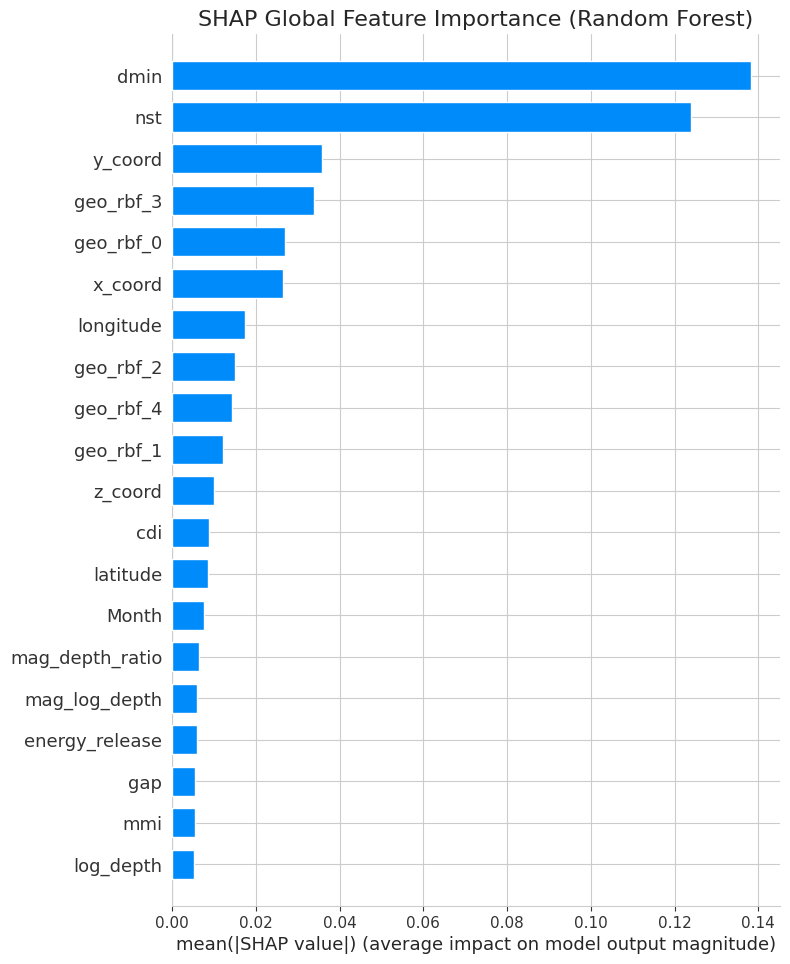

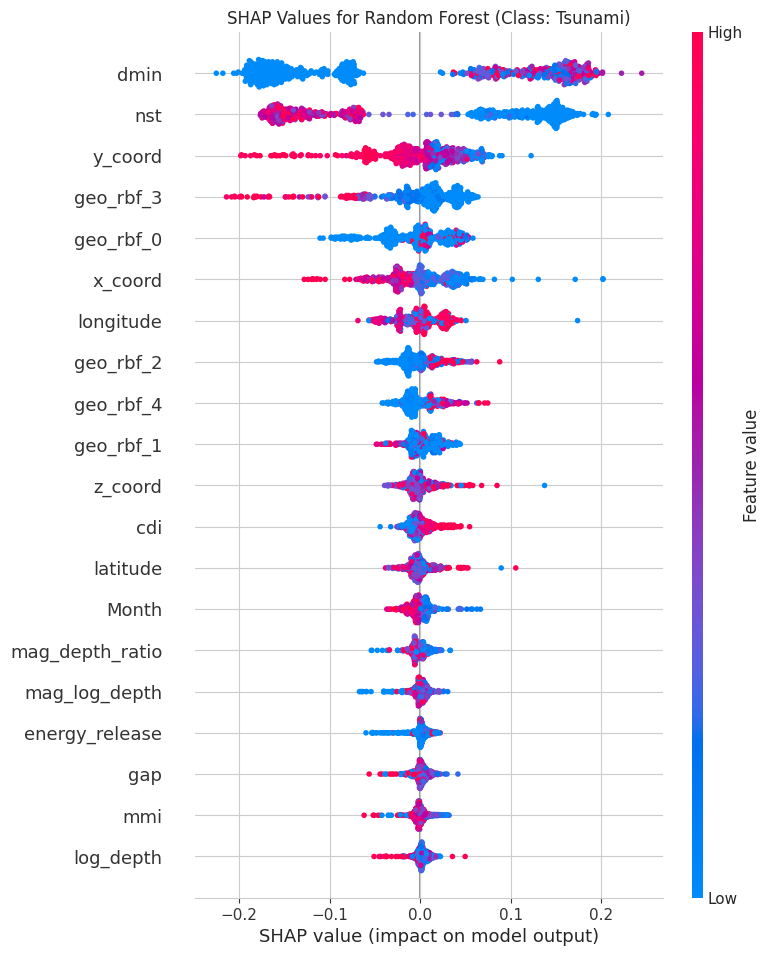

In [18]:
X_train_shap_df = pd.DataFrame(X_train_proc, columns=feature_names)
explainer = shap.TreeExplainer(rf_model)

shap_values = explainer.shap_values(X_train_shap_df, check_additivity=False)

shap_values_target = shap_values[1] 
mean_abs_shap = np.abs(shap_values_target).mean(axis=0)

shap_importance_df = pd.DataFrame({
    'Feature': X_train_shap_df.columns,
    'SHAP_Score': mean_abs_shap
})

shap_importance_df = shap_importance_df.sort_values(by='SHAP_Score', ascending=False).reset_index(drop=True)

print("\n📊 Importance features ranking:")
print(shap_importance_df)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_target, X_train_shap_df, plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance (Random Forest)", fontsize=16)
plt.show()
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_target, X_train_shap_df, show=False)
plt.title("SHAP Values for Random Forest (Class: Tsunami)")
plt.show()


### ✅ Key Insights

- **A small subset of features dominates model decisions** across both MDI (Gain) and SHAP analyses.  
  In particular, `dmin` and `nst` are consistently ranked as the most influential features, indicating that **seismic network and event-level characteristics** play a critical role.

- **Geospatial information is captured more effectively through continuous representations**.  
  Cartesian coordinates (`x_coord`, `y_coord`) and adaptive geospatial RBF features (`geo_rbf_*`) rank higher than raw latitude/longitude, confirming the benefit of **spherical and region-aware encoding**.

- **Physics-informed interaction features contribute moderately**, but are not dominant.  
  Features such as `mag_depth_ratio`, `mag_log_depth`, and energy-related proxies provide complementary information rather than primary decision drivers.

- **Binary heuristic features show negligible contribution**.  
  The feature `is_shallow` consistently ranks at the bottom in both Gain and SHAP analyses, indicating **minimal marginal impact on model predictions** once continuous depth-related features are present.

---

### 🧹 Feature Pruning Decision

Based on its **consistently low importance** and redundancy with continuous depth features,  
**`is_shallow` is removed from the feature set**.

This pruning step:
- Reduces feature noise and model complexity
- Improves interpretability
- Helps prevent overfitting without degrading predictive performance

Overall, the Random Forest primarily relies on **continuous, physically grounded, and spatially coherent features**, reinforcing the robustness and reliability of the final model.


In [19]:
SELECTED_FEATURES = ['magnitude',
 'cdi',
 'mmi',
 'sig',
 'nst',
 'dmin',
 'gap',
 'depth',
 'latitude',
 'longitude',
 'Month',
 'log_depth',
 'log_sig',
 'energy_release',
 'log_energy',
 'mag_depth_ratio',
 'mag_log_depth',
# 'is_shallow',
 'is_major',
 'tsunami_potential',
 'x_coord',
 'y_coord',
 'z_coord',
 'geo_rbf_0',
 'geo_rbf_1',
 'geo_rbf_2',
 'geo_rbf_3',
 'geo_rbf_4',]

In [20]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        valid_cols = [c for c in self.feature_names if c in X.columns]
        return X[valid_cols]

## 🎚️ Threshold Optimization

To better reflect the asymmetric cost of errors in tsunami prediction, we optimize the **decision threshold** instead of using the default value (0.5).

- **Method:**  
  Out-of-fold predicted probabilities are generated via 5-fold cross-validation.
- **Objective:**  
  Maximize **F2-score (β = 2)**, prioritizing recall to minimize false negatives.
---

## 🤖 Final Training & Test Evaluation

### 🔧 Final Training
Using the optimized hyperparameters and threshold, the full pipeline is retrained on the **entire training set**:



🎯 Running CV to find best threshold decision for Random Forest...

🏆 Optimization result (Random Forest):
   • Best Threshold: 0.3300
   • Max CV F2-Score: 0.9016


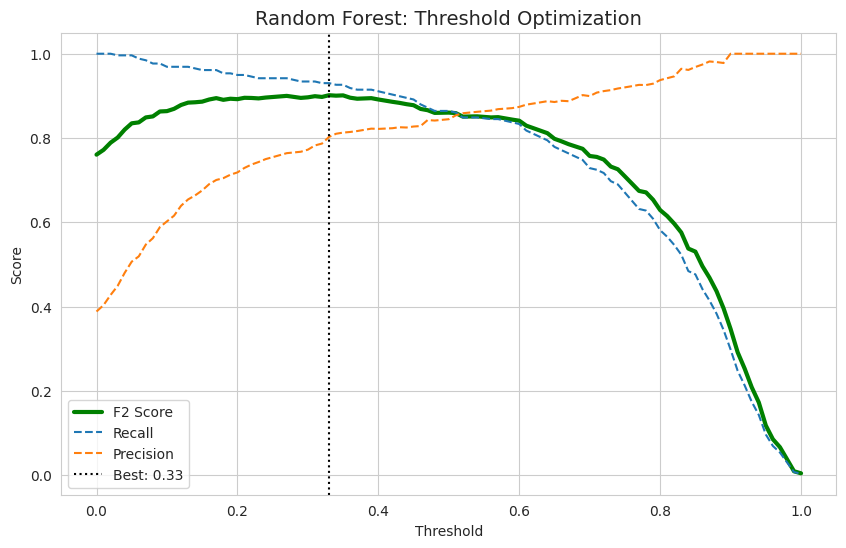


🤖 Training with all training set...

🔮 Evaluate on the test set with best threshold 0.3300...
------------------------------------------------------------
              precision    recall  f1-score   support

        Safe       0.99      0.93      0.96        72
     Tsunami       0.90      0.98      0.94        46

    accuracy                           0.95       118
   macro avg       0.94      0.95      0.95       118
weighted avg       0.95      0.95      0.95       118

Final F2-Score (Test): 0.9615


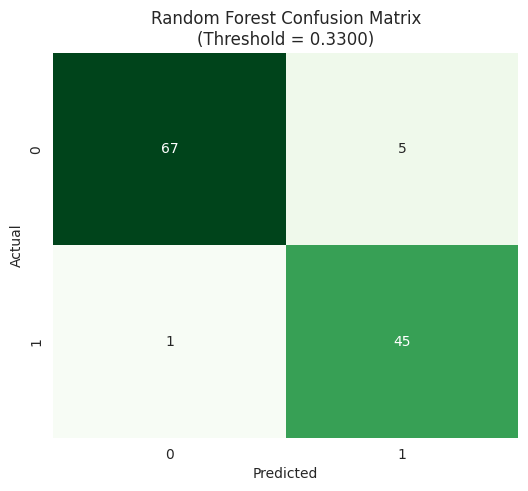

In [21]:
rf_params = {
    'n_estimators': 100,
    'max_depth': 20,
    'n_jobs': -1,
    'random_state': SEED 
}

rf_model = RandomForestClassifier(**rf_params)

rf_pipeline = Pipeline([
    ('physics', PhysicsFeatureGenerator()),
    ('geo_rbf', AdaptiveSphericalRBF()),
    ('selector', FeatureSelector(SELECTED_FEATURES)),
    ('scaler', RobustScaler()),
    ('model', rf_model)
])

print("🎯 Running CV to find best threshold decision for Random Forest...")

y_probas_cv = cross_val_predict(
    rf_pipeline, 
    X_train, 
    y_train, 
    cv=5, 
    method='predict_proba', 
    n_jobs=-1
)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_train, y_probas_cv)
f2_scores = (5 * precisions * recalls) / (4 * precisions + recalls + 1e-9)

best_idx = np.argmax(f2_scores)
best_threshold_rf = thresholds[best_idx]
best_f2_rf = f2_scores[best_idx]

print(f"\n🏆 Optimization result (Random Forest):")
print(f"   • Best Threshold: {best_threshold_rf:.4f}")
print(f"   • Max CV F2-Score: {best_f2_rf:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f2_scores[:-1], label='F2 Score', color='green', linewidth=3)
plt.plot(thresholds, recalls[:-1], label='Recall', linestyle='--')
plt.plot(thresholds, precisions[:-1], label='Precision', linestyle='--')
plt.axvline(best_threshold_rf, color='black', linestyle=':', label=f'Best: {best_threshold_rf:.2f}')
plt.title('Random Forest: Threshold Optimization', fontsize=14)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

print("\n🤖 Training with all training set...")
rf_pipeline.fit(X_train, y_train)

print(f"\n🔮 Evaluate on the test set with best threshold {best_threshold_rf:.4f}...")
y_test_proba = rf_pipeline.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= best_threshold_rf).astype(int)

# report
print("-" * 60)
print(classification_report(y_test, y_test_pred, target_names=['Safe', 'Tsunami']))
print(f"Final F2-Score (Test): {fbeta_score(y_test, y_test_pred, beta=2):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title(f'Random Forest Confusion Matrix\n(Threshold = {best_threshold_rf:.4f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### 🔮 Test Set Performance (Threshold = 0.33)

- **Final F2-score (Test):** **0.9615**
- **Tsunami class:**
  - Recall: **0.98**
  - Precision: **0.90**
- **Overall accuracy:** **0.95**

**Confusion Matrix (Test Set):**
- True Positives: **45**
- False Negatives: **1**
- False Positives: **5**
- True Negatives: **67**

These results confirm that threshold optimization **substantially reduces missed tsunami events**, while keeping false alarms at a manageable level.



## 🏁 Conclusion

This study presents a **robust, physics-informed and geospatially adaptive framework** for tsunami prediction using machine learning.

By integrating:
- **Seismological knowledge** through physics-based feature engineering,
- **Spherical Earth representation** and adaptive geospatial RBF encoding,
- **Random Forest** as a stable and high-performing classifier,
- **Recall-oriented optimization** via F2-score and decision threshold tuning,

the proposed approach achieves **strong generalization and high reliability**.

The final model reaches a **test F2-score of 0.96** with **98% recall for tsunami events**, successfully minimizing false negatives while maintaining controlled false alarms. Feature importance analysis further confirms that the model relies on **physically meaningful and spatially coherent signals**, rather than heuristic thresholds.

The results demonstrate that **domain-informed feature design combined with careful decision optimization** is key to deploying machine learning models in high-stakes natural hazard prediction tasks.
